# Model Training
Finally we get to the good stuff. We will use polynomial regression which will probably suck due to too many oscillations in the train dataset, randomforest which might actually work decently well, and lgbm which I am not too familiar with, and will probably fail utilising well. I'm pretty sure lags/rolls should have been implemented differently but I guess you live and learn. Noone said this project has to win the competition that has been closed for like 2 years anyway.

### WRMSSE Calculation
As mentioned in notebook 1, these metrics will be used to determine our models score.
Big thanks to sakami for this implementation:
https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

Note that due to having a competition leaderboard, we will forgo making a baseline model in lieu of a simple score comparison.

I will also refrain from reformatting the results into the proper submission format as there is nothing to submit anyway. The WRMSSE scores should be good enough to judge the models, I might go back to this and add it later, but for now this will have to do.

In [1]:
from typing import Union

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm


class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

## Imports and reading data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from downcast import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.model_selection import KFold

In [3]:
train = pd.read_pickle('df_train_final.pkl')
test = pd.read_pickle('df_test_final.pkl')

train = train.reset_index().set_index('date')
test = test.reset_index().set_index('date')

train = reduce(train)
test = reduce(test)

## Feature selection and final splits

In [4]:
train.columns

Index(['index', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'wm_yr_wk', 'wday', 'month', 'year', 'items_sold', 'sell_price',
       'event_num', 'snap', 'weekend', 'season', 'item_id_label',
       'dept_id_label', 'cat_id_label', 'store_id_label', 'state_id_label',
       'lag_7', 'lag_28', 'lag_35', 'lag_42', 'lag_60', 'lag_360', 'rmean_7_7',
       'rmean_28_7', 'rmean_35_7', 'rmean_42_7', 'rmean_60_7', 'rmean_360_7',
       'rmean_7_28', 'rmean_28_28', 'rmean_35_28', 'rmean_42_28',
       'rmean_60_28', 'rmean_360_28', 'rmean_7_35', 'rmean_28_35',
       'rmean_35_35', 'rmean_42_35', 'rmean_60_35', 'rmean_360_35',
       'rmean_7_42', 'rmean_28_42', 'rmean_35_42', 'rmean_42_42',
       'rmean_60_42', 'rmean_360_42', 'rmean_7_60', 'rmean_28_60',
       'rmean_35_60', 'rmean_42_60', 'rmean_60_60', 'rmean_360_60',
       'rmean_7_360', 'rmean_28_360', 'rmean_35_360', 'rmean_42_360',
       'rmean_60_360', 'rmean_360_360'],
      dtype='object')

In [5]:
unused = ['index', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','wm_yr_wk','items_sold',]
features = list(set(train.columns)-set(unused))
target = ['items_sold']

In [6]:
features

['rmean_360_7',
 'rmean_360_360',
 'item_id_label',
 'event_num',
 'rmean_7_42',
 'lag_7',
 'year',
 'lag_360',
 'lag_28',
 'rmean_360_35',
 'rmean_60_60',
 'rmean_7_28',
 'rmean_28_60',
 'rmean_7_360',
 'weekend',
 'rmean_42_42',
 'season',
 'rmean_60_28',
 'rmean_35_60',
 'rmean_7_60',
 'rmean_35_28',
 'month',
 'rmean_42_35',
 'rmean_35_35',
 'wday',
 'rmean_28_7',
 'lag_35',
 'rmean_360_60',
 'rmean_360_42',
 'rmean_60_42',
 'rmean_35_42',
 'rmean_42_360',
 'rmean_60_7',
 'rmean_60_360',
 'rmean_7_35',
 'rmean_35_7',
 'rmean_360_28',
 'lag_42',
 'snap',
 'rmean_28_28',
 'sell_price',
 'rmean_42_7',
 'state_id_label',
 'rmean_35_360',
 'rmean_42_60',
 'rmean_60_35',
 'lag_60',
 'rmean_7_7',
 'store_id_label',
 'rmean_42_28',
 'dept_id_label',
 'rmean_28_35',
 'cat_id_label',
 'rmean_28_42',
 'rmean_28_360']

In [7]:
X_train = train[features].fillna(0)
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [8]:
# We have data from 2014-2016 so 3 splits seems pretty good
tss = TimeSeriesSplit(n_splits=3)

## 1. Linear Regression
For the purpose of polynomial regression we will remove all the lags/rolling features because my pc blows up. Those are really only there for LGBM anyway.

In [9]:
X_train_nolags = X_train[['weekend','cat_id_label','event_num','season','sell_price',
                       'snap','month','wday','year','store_id_label','state_id_label']]
X_test_nolags = X_test[['weekend','cat_id_label','event_num','season','sell_price',
                       'snap','month','wday','year','store_id_label','state_id_label']]

In [10]:
linear_reg= make_pipeline(StandardScaler(), LinearRegression())
params = {}
linear_reg_gridsearch = GridSearchCV(
    linear_reg, 
    params,
    scoring='neg_mean_squared_error',
    cv=tss,
    n_jobs = None,
    verbose=10)

linear_reg_gridsearch.fit(X_train_nolags, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START ............................................................
[CV 1/3; 1/1] END ............................, score=-11.401 total time=   2.3s
[CV 2/3; 1/1] START ............................................................
[CV 2/3; 1/1] END ............................, score=-13.182 total time=   4.0s
[CV 3/3; 1/1] START ............................................................
[CV 3/3; 1/1] END ............................, score=-12.090 total time=   6.2s


# 2. Random Forest
We will use the same nolags model for our trees.

In [12]:
random_forest = RandomForestRegressor(n_jobs=-1,max_features=0.33)

params_rf = {'max_depth': [2, 3, 5, 10, 20],
             'min_samples_leaf': [7, 14, 28, 56],
             'n_estimators': [7,14,28]} #the number of decision trees you will be running in the model/the number of trees in the forest.

rf_gridsearch = GridSearchCV(random_forest,
                             params_rf, 
                             scoring='neg_mean_absolute_error',
                             cv=tss,
                             verbose=10, 
                             n_jobs=None)
rf_gridsearch.fit(X_train_nolags, y_train.values.ravel())
random_forest = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3; 1/60] START max_depth=2, min_samples_leaf=7, n_estimators=7............
[CV 1/3; 1/60] END max_depth=2, min_samples_leaf=7, n_estimators=7;, score=-1.502 total time=   3.2s
[CV 2/3; 1/60] START max_depth=2, min_samples_leaf=7, n_estimators=7............
[CV 2/3; 1/60] END max_depth=2, min_samples_leaf=7, n_estimators=7;, score=-1.530 total time=   5.5s
[CV 3/3; 1/60] START max_depth=2, min_samples_leaf=7, n_estimators=7............
[CV 3/3; 1/60] END max_depth=2, min_samples_leaf=7, n_estimators=7;, score=-1.534 total time=   7.9s
[CV 1/3; 2/60] START max_depth=2, min_samples_leaf=7, n_estimators=14...........
[CV 1/3; 2/60] END max_depth=2, min_samples_leaf=7, n_estimators=14;, score=-1.489 total time=   5.0s
[CV 2/3; 2/60] START max_depth=2, min_samples_leaf=7, n_estimators=14...........
[CV 2/3; 2/60] END max_depth=2, min_samples_leaf=7, n_estimators=14;, score=-1.514 total time=   9.9s
[CV 3/3; 2/60] START max_d

[CV 3/3; 15/60] END max_depth=3, min_samples_leaf=7, n_estimators=28;, score=-1.525 total time=  34.6s
[CV 1/3; 16/60] START max_depth=3, min_samples_leaf=14, n_estimators=7..........
[CV 1/3; 16/60] END max_depth=3, min_samples_leaf=14, n_estimators=7;, score=-1.473 total time=   3.9s
[CV 2/3; 16/60] START max_depth=3, min_samples_leaf=14, n_estimators=7..........
[CV 2/3; 16/60] END max_depth=3, min_samples_leaf=14, n_estimators=7;, score=-1.517 total time=   6.8s
[CV 3/3; 16/60] START max_depth=3, min_samples_leaf=14, n_estimators=7..........
[CV 3/3; 16/60] END max_depth=3, min_samples_leaf=14, n_estimators=7;, score=-1.530 total time=  11.8s
[CV 1/3; 17/60] START max_depth=3, min_samples_leaf=14, n_estimators=14.........
[CV 1/3; 17/60] END max_depth=3, min_samples_leaf=14, n_estimators=14;, score=-1.472 total time=   6.9s
[CV 2/3; 17/60] START max_depth=3, min_samples_leaf=14, n_estimators=14.........
[CV 2/3; 17/60] END max_depth=3, min_samples_leaf=14, n_estimators=14;, score=-

[CV 3/3; 30/60] END max_depth=5, min_samples_leaf=14, n_estimators=28;, score=-1.504 total time= 1.0min
[CV 1/3; 31/60] START max_depth=5, min_samples_leaf=28, n_estimators=7..........
[CV 1/3; 31/60] END max_depth=5, min_samples_leaf=28, n_estimators=7;, score=-1.465 total time=   5.4s
[CV 2/3; 31/60] START max_depth=5, min_samples_leaf=28, n_estimators=7..........
[CV 2/3; 31/60] END max_depth=5, min_samples_leaf=28, n_estimators=7;, score=-1.493 total time=  10.0s
[CV 3/3; 31/60] START max_depth=5, min_samples_leaf=28, n_estimators=7..........
[CV 3/3; 31/60] END max_depth=5, min_samples_leaf=28, n_estimators=7;, score=-1.500 total time=  13.9s
[CV 1/3; 32/60] START max_depth=5, min_samples_leaf=28, n_estimators=14.........
[CV 1/3; 32/60] END max_depth=5, min_samples_leaf=28, n_estimators=14;, score=-1.457 total time=   9.1s
[CV 2/3; 32/60] START max_depth=5, min_samples_leaf=28, n_estimators=14.........
[CV 2/3; 32/60] END max_depth=5, min_samples_leaf=28, n_estimators=14;, score=

[CV 3/3; 45/60] END max_depth=10, min_samples_leaf=28, n_estimators=28;, score=-1.467 total time= 1.7min
[CV 1/3; 46/60] START max_depth=10, min_samples_leaf=56, n_estimators=7.........
[CV 1/3; 46/60] END max_depth=10, min_samples_leaf=56, n_estimators=7;, score=-1.431 total time=   7.0s
[CV 2/3; 46/60] START max_depth=10, min_samples_leaf=56, n_estimators=7.........
[CV 2/3; 46/60] END max_depth=10, min_samples_leaf=56, n_estimators=7;, score=-1.458 total time=  16.0s
[CV 3/3; 46/60] START max_depth=10, min_samples_leaf=56, n_estimators=7.........
[CV 3/3; 46/60] END max_depth=10, min_samples_leaf=56, n_estimators=7;, score=-1.469 total time=  32.1s
[CV 1/3; 47/60] START max_depth=10, min_samples_leaf=56, n_estimators=14........
[CV 1/3; 47/60] END max_depth=10, min_samples_leaf=56, n_estimators=14;, score=-1.425 total time=  14.7s
[CV 2/3; 47/60] START max_depth=10, min_samples_leaf=56, n_estimators=14........
[CV 2/3; 47/60] END max_depth=10, min_samples_leaf=56, n_estimators=14;, 

[CV 3/3; 60/60] END max_depth=20, min_samples_leaf=56, n_estimators=28;, score=-1.437 total time= 2.5min


In [15]:
random_forest

RandomForestRegressor(max_depth=20, max_features=0.33, min_samples_leaf=7,
                      n_estimators=28, n_jobs=-1)

## 3.  LGBM Regression

In [16]:
param_dist = {
    'boosting_type': ['gbdt'],
    'objective': ['tweedie'],
    'tweedie_variance_power': [1.1],
    'n_estimators': [500],
    'metric': ['rmse'],
    'max_depth': [30, 50, 70],
    'num_leaves': [250, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'feature_fraction': [0.5, 0.7],
    'bagging_fraction': [0.5, 0.7],
}

reg = lgb.LGBMRegressor()

In [17]:
random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=5,
    cv=tss,
    scoring='neg_mean_squared_error',
    n_jobs=None,
)

In [18]:
random_search.fit(
    X_train,
    y_train,
    eval_metric='rmse',
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

[1]	valid_0's rmse: 3.5002	valid_1's rmse: 3.52516
[2]	valid_0's rmse: 3.36775	valid_1's rmse: 3.38049
[3]	valid_0's rmse: 3.22629	valid_1's rmse: 3.22757
[4]	valid_0's rmse: 3.08721	valid_1's rmse: 3.076
[5]	valid_0's rmse: 2.95661	valid_1's rmse: 2.93594
[6]	valid_0's rmse: 2.83983	valid_1's rmse: 2.80972
[7]	valid_0's rmse: 2.73715	valid_1's rmse: 2.69694
[8]	valid_0's rmse: 2.64789	valid_1's rmse: 2.59915
[9]	valid_0's rmse: 2.57265	valid_1's rmse: 2.51367
[10]	valid_0's rmse: 2.50618	valid_1's rmse: 2.43846
[11]	valid_0's rmse: 2.45075	valid_1's rmse: 2.37641
[12]	valid_0's rmse: 2.40388	valid_1's rmse: 2.32384
[13]	valid_0's rmse: 2.36421	valid_1's rmse: 2.27935
[14]	valid_0's rmse: 2.33191	valid_1's rmse: 2.24169
[15]	valid_0's rmse: 2.30456	valid_1's rmse: 2.20932
[16]	valid_0's rmse: 2.28154	valid_1's rmse: 2.18365
[17]	valid_0's rmse: 2.26379	valid_1's rmse: 2.16322
[18]	valid_0's rmse: 2.24806	valid_1's rmse: 2.14423
[19]	valid_0's rmse: 2.2349	valid_1's rmse: 2.12867
[20]	v

[156]	valid_0's rmse: 2.13153	valid_1's rmse: 2.0805
[157]	valid_0's rmse: 2.13142	valid_1's rmse: 2.08022
[158]	valid_0's rmse: 2.13118	valid_1's rmse: 2.08079
[159]	valid_0's rmse: 2.1312	valid_1's rmse: 2.08077
[160]	valid_0's rmse: 2.13086	valid_1's rmse: 2.08082
[161]	valid_0's rmse: 2.13069	valid_1's rmse: 2.0812
[162]	valid_0's rmse: 2.13064	valid_1's rmse: 2.0812
[163]	valid_0's rmse: 2.13059	valid_1's rmse: 2.08125
[164]	valid_0's rmse: 2.13055	valid_1's rmse: 2.0812
[165]	valid_0's rmse: 2.13026	valid_1's rmse: 2.08151
[166]	valid_0's rmse: 2.13021	valid_1's rmse: 2.08171
[167]	valid_0's rmse: 2.13021	valid_1's rmse: 2.08178
[168]	valid_0's rmse: 2.12998	valid_1's rmse: 2.08224
[169]	valid_0's rmse: 2.12994	valid_1's rmse: 2.08234
[170]	valid_0's rmse: 2.1298	valid_1's rmse: 2.08242
[171]	valid_0's rmse: 2.1297	valid_1's rmse: 2.08286
[172]	valid_0's rmse: 2.12956	valid_1's rmse: 2.08305
[173]	valid_0's rmse: 2.12956	valid_1's rmse: 2.08307
[174]	valid_0's rmse: 2.12948	valid

[309]	valid_0's rmse: 2.11964	valid_1's rmse: 2.11052
[310]	valid_0's rmse: 2.11987	valid_1's rmse: 2.11086
[311]	valid_0's rmse: 2.11993	valid_1's rmse: 2.11091
[312]	valid_0's rmse: 2.11996	valid_1's rmse: 2.11095
[313]	valid_0's rmse: 2.11995	valid_1's rmse: 2.11095
[314]	valid_0's rmse: 2.1199	valid_1's rmse: 2.11079
[315]	valid_0's rmse: 2.1199	valid_1's rmse: 2.11079
[316]	valid_0's rmse: 2.1198	valid_1's rmse: 2.11074
[317]	valid_0's rmse: 2.1198	valid_1's rmse: 2.11072
[318]	valid_0's rmse: 2.11979	valid_1's rmse: 2.11076
[319]	valid_0's rmse: 2.11986	valid_1's rmse: 2.11103
[320]	valid_0's rmse: 2.11976	valid_1's rmse: 2.11102
[321]	valid_0's rmse: 2.11972	valid_1's rmse: 2.11148
[322]	valid_0's rmse: 2.11969	valid_1's rmse: 2.1115
[323]	valid_0's rmse: 2.11975	valid_1's rmse: 2.11177
[324]	valid_0's rmse: 2.11971	valid_1's rmse: 2.11194
[325]	valid_0's rmse: 2.11974	valid_1's rmse: 2.11194
[326]	valid_0's rmse: 2.11965	valid_1's rmse: 2.11193
[327]	valid_0's rmse: 2.11958	val

[462]	valid_0's rmse: 2.11682	valid_1's rmse: 2.1296
[463]	valid_0's rmse: 2.11673	valid_1's rmse: 2.13011
[464]	valid_0's rmse: 2.11673	valid_1's rmse: 2.13023
[465]	valid_0's rmse: 2.11661	valid_1's rmse: 2.13028
[466]	valid_0's rmse: 2.11658	valid_1's rmse: 2.1303
[467]	valid_0's rmse: 2.11658	valid_1's rmse: 2.1303
[468]	valid_0's rmse: 2.11651	valid_1's rmse: 2.13032
[469]	valid_0's rmse: 2.11642	valid_1's rmse: 2.1303
[470]	valid_0's rmse: 2.11643	valid_1's rmse: 2.13026
[471]	valid_0's rmse: 2.11625	valid_1's rmse: 2.13002
[472]	valid_0's rmse: 2.11624	valid_1's rmse: 2.13003
[473]	valid_0's rmse: 2.11632	valid_1's rmse: 2.1301
[474]	valid_0's rmse: 2.11625	valid_1's rmse: 2.13024
[475]	valid_0's rmse: 2.11623	valid_1's rmse: 2.13025
[476]	valid_0's rmse: 2.11621	valid_1's rmse: 2.13026
[477]	valid_0's rmse: 2.11619	valid_1's rmse: 2.13025
[478]	valid_0's rmse: 2.11639	valid_1's rmse: 2.1305
[479]	valid_0's rmse: 2.1164	valid_1's rmse: 2.13053
[480]	valid_0's rmse: 2.11637	valid

[112]	valid_0's rmse: 2.07376	valid_1's rmse: 2.08433
[113]	valid_0's rmse: 2.07343	valid_1's rmse: 2.08467
[114]	valid_0's rmse: 2.07326	valid_1's rmse: 2.08443
[115]	valid_0's rmse: 2.07302	valid_1's rmse: 2.08451
[116]	valid_0's rmse: 2.07229	valid_1's rmse: 2.08453
[117]	valid_0's rmse: 2.07137	valid_1's rmse: 2.08479
[118]	valid_0's rmse: 2.07108	valid_1's rmse: 2.08475
[119]	valid_0's rmse: 2.07086	valid_1's rmse: 2.08468
[120]	valid_0's rmse: 2.07159	valid_1's rmse: 2.08769
[121]	valid_0's rmse: 2.071	valid_1's rmse: 2.08769
[122]	valid_0's rmse: 2.07085	valid_1's rmse: 2.08776
[123]	valid_0's rmse: 2.07205	valid_1's rmse: 2.09215
[124]	valid_0's rmse: 2.07192	valid_1's rmse: 2.09216
[125]	valid_0's rmse: 2.07127	valid_1's rmse: 2.09197
[126]	valid_0's rmse: 2.07057	valid_1's rmse: 2.09314
[127]	valid_0's rmse: 2.07047	valid_1's rmse: 2.1004
[128]	valid_0's rmse: 2.06969	valid_1's rmse: 2.10077
[129]	valid_0's rmse: 2.06883	valid_1's rmse: 2.10043
[130]	valid_0's rmse: 2.06892	v

[265]	valid_0's rmse: 2.0371	valid_1's rmse: 2.12991
[266]	valid_0's rmse: 2.03706	valid_1's rmse: 2.1299
[267]	valid_0's rmse: 2.0368	valid_1's rmse: 2.12987
[268]	valid_0's rmse: 2.03651	valid_1's rmse: 2.12989
[269]	valid_0's rmse: 2.03665	valid_1's rmse: 2.13091
[270]	valid_0's rmse: 2.03646	valid_1's rmse: 2.13019
[271]	valid_0's rmse: 2.03602	valid_1's rmse: 2.13018
[272]	valid_0's rmse: 2.03722	valid_1's rmse: 2.13342
[273]	valid_0's rmse: 2.03721	valid_1's rmse: 2.13343
[274]	valid_0's rmse: 2.03698	valid_1's rmse: 2.13357
[275]	valid_0's rmse: 2.03674	valid_1's rmse: 2.13378
[276]	valid_0's rmse: 2.03639	valid_1's rmse: 2.13375
[277]	valid_0's rmse: 2.03611	valid_1's rmse: 2.13379
[278]	valid_0's rmse: 2.03548	valid_1's rmse: 2.13376
[279]	valid_0's rmse: 2.03534	valid_1's rmse: 2.13474
[280]	valid_0's rmse: 2.03544	valid_1's rmse: 2.13478
[281]	valid_0's rmse: 2.03476	valid_1's rmse: 2.13474
[282]	valid_0's rmse: 2.03472	valid_1's rmse: 2.13474
[283]	valid_0's rmse: 2.03459	v

[418]	valid_0's rmse: 2.01258	valid_1's rmse: 2.14607
[419]	valid_0's rmse: 2.01259	valid_1's rmse: 2.14608
[420]	valid_0's rmse: 2.01221	valid_1's rmse: 2.14673
[421]	valid_0's rmse: 2.01198	valid_1's rmse: 2.14639
[422]	valid_0's rmse: 2.0119	valid_1's rmse: 2.14645
[423]	valid_0's rmse: 2.01176	valid_1's rmse: 2.1465
[424]	valid_0's rmse: 2.01167	valid_1's rmse: 2.14651
[425]	valid_0's rmse: 2.01153	valid_1's rmse: 2.14662
[426]	valid_0's rmse: 2.01141	valid_1's rmse: 2.14671
[427]	valid_0's rmse: 2.01109	valid_1's rmse: 2.14673
[428]	valid_0's rmse: 2.0109	valid_1's rmse: 2.14674
[429]	valid_0's rmse: 2.0105	valid_1's rmse: 2.14673
[430]	valid_0's rmse: 2.01053	valid_1's rmse: 2.1473
[431]	valid_0's rmse: 2.00996	valid_1's rmse: 2.14745
[432]	valid_0's rmse: 2.00988	valid_1's rmse: 2.14757
[433]	valid_0's rmse: 2.0096	valid_1's rmse: 2.14757
[434]	valid_0's rmse: 2.00939	valid_1's rmse: 2.14772
[435]	valid_0's rmse: 2.00913	valid_1's rmse: 2.14769
[436]	valid_0's rmse: 2.00981	vali

[68]	valid_0's rmse: 2.08253	valid_1's rmse: 2.06578
[69]	valid_0's rmse: 2.08139	valid_1's rmse: 2.06677
[70]	valid_0's rmse: 2.07991	valid_1's rmse: 2.06995
[71]	valid_0's rmse: 2.07921	valid_1's rmse: 2.06994
[72]	valid_0's rmse: 2.07879	valid_1's rmse: 2.06983
[73]	valid_0's rmse: 2.07844	valid_1's rmse: 2.06985
[74]	valid_0's rmse: 2.07718	valid_1's rmse: 2.06963
[75]	valid_0's rmse: 2.07703	valid_1's rmse: 2.06934
[76]	valid_0's rmse: 2.07577	valid_1's rmse: 2.07241
[77]	valid_0's rmse: 2.07526	valid_1's rmse: 2.07239
[78]	valid_0's rmse: 2.07452	valid_1's rmse: 2.07238
[79]	valid_0's rmse: 2.07368	valid_1's rmse: 2.07225
[80]	valid_0's rmse: 2.07322	valid_1's rmse: 2.07231
[81]	valid_0's rmse: 2.07288	valid_1's rmse: 2.07231
[82]	valid_0's rmse: 2.072	valid_1's rmse: 2.07254
[83]	valid_0's rmse: 2.07134	valid_1's rmse: 2.07595
[84]	valid_0's rmse: 2.07059	valid_1's rmse: 2.07571
[85]	valid_0's rmse: 2.06919	valid_1's rmse: 2.07506
[86]	valid_0's rmse: 2.06864	valid_1's rmse: 2.0

[222]	valid_0's rmse: 1.98585	valid_1's rmse: 2.11453
[223]	valid_0's rmse: 1.98494	valid_1's rmse: 2.11478
[224]	valid_0's rmse: 1.98476	valid_1's rmse: 2.11456
[225]	valid_0's rmse: 1.98447	valid_1's rmse: 2.11432
[226]	valid_0's rmse: 1.98366	valid_1's rmse: 2.11441
[227]	valid_0's rmse: 1.98338	valid_1's rmse: 2.1145
[228]	valid_0's rmse: 1.98279	valid_1's rmse: 2.11458
[229]	valid_0's rmse: 1.98273	valid_1's rmse: 2.11457
[230]	valid_0's rmse: 1.98188	valid_1's rmse: 2.11486
[231]	valid_0's rmse: 1.98145	valid_1's rmse: 2.11487
[232]	valid_0's rmse: 1.98128	valid_1's rmse: 2.11487
[233]	valid_0's rmse: 1.98036	valid_1's rmse: 2.11492
[234]	valid_0's rmse: 1.98013	valid_1's rmse: 2.11493
[235]	valid_0's rmse: 1.97993	valid_1's rmse: 2.11491
[236]	valid_0's rmse: 1.97939	valid_1's rmse: 2.11488
[237]	valid_0's rmse: 1.97914	valid_1's rmse: 2.11476
[238]	valid_0's rmse: 1.97858	valid_1's rmse: 2.11488
[239]	valid_0's rmse: 1.97808	valid_1's rmse: 2.11497
[240]	valid_0's rmse: 1.97759

[375]	valid_0's rmse: 1.93403	valid_1's rmse: 2.13566
[376]	valid_0's rmse: 1.93402	valid_1's rmse: 2.13559
[377]	valid_0's rmse: 1.93381	valid_1's rmse: 2.13566
[378]	valid_0's rmse: 1.93376	valid_1's rmse: 2.13566
[379]	valid_0's rmse: 1.9334	valid_1's rmse: 2.13554
[380]	valid_0's rmse: 1.93332	valid_1's rmse: 2.1356
[381]	valid_0's rmse: 1.93322	valid_1's rmse: 2.1356
[382]	valid_0's rmse: 1.93309	valid_1's rmse: 2.1356
[383]	valid_0's rmse: 1.93291	valid_1's rmse: 2.13559
[384]	valid_0's rmse: 1.93269	valid_1's rmse: 2.13567
[385]	valid_0's rmse: 1.93252	valid_1's rmse: 2.13568
[386]	valid_0's rmse: 1.93221	valid_1's rmse: 2.13571
[387]	valid_0's rmse: 1.9322	valid_1's rmse: 2.1357
[388]	valid_0's rmse: 1.93212	valid_1's rmse: 2.1357
[389]	valid_0's rmse: 1.93198	valid_1's rmse: 2.13565
[390]	valid_0's rmse: 1.93181	valid_1's rmse: 2.13565
[391]	valid_0's rmse: 1.93175	valid_1's rmse: 2.13588
[392]	valid_0's rmse: 1.93157	valid_1's rmse: 2.13589
[393]	valid_0's rmse: 1.93138	valid

[24]	valid_0's rmse: 2.20111	valid_1's rmse: 2.09097
[25]	valid_0's rmse: 2.19612	valid_1's rmse: 2.08552
[26]	valid_0's rmse: 2.1919	valid_1's rmse: 2.08086
[27]	valid_0's rmse: 2.1882	valid_1's rmse: 2.07766
[28]	valid_0's rmse: 2.18312	valid_1's rmse: 2.07489
[29]	valid_0's rmse: 2.18099	valid_1's rmse: 2.07304
[30]	valid_0's rmse: 2.17866	valid_1's rmse: 2.07082
[31]	valid_0's rmse: 2.17683	valid_1's rmse: 2.06941
[32]	valid_0's rmse: 2.17475	valid_1's rmse: 2.06791
[33]	valid_0's rmse: 2.17336	valid_1's rmse: 2.06621
[34]	valid_0's rmse: 2.17232	valid_1's rmse: 2.06544
[35]	valid_0's rmse: 2.1707	valid_1's rmse: 2.06504
[36]	valid_0's rmse: 2.1692	valid_1's rmse: 2.06399
[37]	valid_0's rmse: 2.16847	valid_1's rmse: 2.06418
[38]	valid_0's rmse: 2.16748	valid_1's rmse: 2.06343
[39]	valid_0's rmse: 2.16625	valid_1's rmse: 2.06353
[40]	valid_0's rmse: 2.16489	valid_1's rmse: 2.06283
[41]	valid_0's rmse: 2.16411	valid_1's rmse: 2.06256
[42]	valid_0's rmse: 2.163	valid_1's rmse: 2.06241

[178]	valid_0's rmse: 2.12613	valid_1's rmse: 2.09468
[179]	valid_0's rmse: 2.12601	valid_1's rmse: 2.0948
[180]	valid_0's rmse: 2.12555	valid_1's rmse: 2.09506
[181]	valid_0's rmse: 2.12579	valid_1's rmse: 2.0956
[182]	valid_0's rmse: 2.12587	valid_1's rmse: 2.0964
[183]	valid_0's rmse: 2.1257	valid_1's rmse: 2.09642
[184]	valid_0's rmse: 2.12583	valid_1's rmse: 2.09631
[185]	valid_0's rmse: 2.12622	valid_1's rmse: 2.09653
[186]	valid_0's rmse: 2.12602	valid_1's rmse: 2.09653
[187]	valid_0's rmse: 2.12614	valid_1's rmse: 2.09697
[188]	valid_0's rmse: 2.12572	valid_1's rmse: 2.09695
[189]	valid_0's rmse: 2.12548	valid_1's rmse: 2.09724
[190]	valid_0's rmse: 2.12548	valid_1's rmse: 2.09717
[191]	valid_0's rmse: 2.12561	valid_1's rmse: 2.09821
[192]	valid_0's rmse: 2.12562	valid_1's rmse: 2.09823
[193]	valid_0's rmse: 2.12542	valid_1's rmse: 2.09802
[194]	valid_0's rmse: 2.12532	valid_1's rmse: 2.09801
[195]	valid_0's rmse: 2.12525	valid_1's rmse: 2.09817
[196]	valid_0's rmse: 2.12515	va

[331]	valid_0's rmse: 2.11657	valid_1's rmse: 2.12321
[332]	valid_0's rmse: 2.11657	valid_1's rmse: 2.12327
[333]	valid_0's rmse: 2.11654	valid_1's rmse: 2.12322
[334]	valid_0's rmse: 2.11638	valid_1's rmse: 2.1234
[335]	valid_0's rmse: 2.11621	valid_1's rmse: 2.12345
[336]	valid_0's rmse: 2.11684	valid_1's rmse: 2.12567
[337]	valid_0's rmse: 2.1168	valid_1's rmse: 2.12562
[338]	valid_0's rmse: 2.11688	valid_1's rmse: 2.1257
[339]	valid_0's rmse: 2.11683	valid_1's rmse: 2.12573
[340]	valid_0's rmse: 2.11681	valid_1's rmse: 2.12569
[341]	valid_0's rmse: 2.11675	valid_1's rmse: 2.12576
[342]	valid_0's rmse: 2.11657	valid_1's rmse: 2.12568
[343]	valid_0's rmse: 2.11673	valid_1's rmse: 2.12577
[344]	valid_0's rmse: 2.11673	valid_1's rmse: 2.12582
[345]	valid_0's rmse: 2.11665	valid_1's rmse: 2.12574
[346]	valid_0's rmse: 2.11657	valid_1's rmse: 2.12575
[347]	valid_0's rmse: 2.11662	valid_1's rmse: 2.12595
[348]	valid_0's rmse: 2.11649	valid_1's rmse: 2.12598
[349]	valid_0's rmse: 2.11645	v

[484]	valid_0's rmse: 2.11405	valid_1's rmse: 2.1424
[485]	valid_0's rmse: 2.11405	valid_1's rmse: 2.1424
[486]	valid_0's rmse: 2.11395	valid_1's rmse: 2.14233
[487]	valid_0's rmse: 2.11391	valid_1's rmse: 2.14233
[488]	valid_0's rmse: 2.11387	valid_1's rmse: 2.14233
[489]	valid_0's rmse: 2.11388	valid_1's rmse: 2.14236
[490]	valid_0's rmse: 2.11378	valid_1's rmse: 2.14238
[491]	valid_0's rmse: 2.11364	valid_1's rmse: 2.14239
[492]	valid_0's rmse: 2.11363	valid_1's rmse: 2.1426
[493]	valid_0's rmse: 2.11374	valid_1's rmse: 2.14262
[494]	valid_0's rmse: 2.11334	valid_1's rmse: 2.14261
[495]	valid_0's rmse: 2.11327	valid_1's rmse: 2.14243
[496]	valid_0's rmse: 2.11309	valid_1's rmse: 2.14244
[497]	valid_0's rmse: 2.11308	valid_1's rmse: 2.14245
[498]	valid_0's rmse: 2.11303	valid_1's rmse: 2.14249
[499]	valid_0's rmse: 2.11301	valid_1's rmse: 2.14298
[500]	valid_0's rmse: 2.11309	valid_1's rmse: 2.14319
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignore

[134]	valid_0's rmse: 2.06364	valid_1's rmse: 2.06757
[135]	valid_0's rmse: 2.06421	valid_1's rmse: 2.07043
[136]	valid_0's rmse: 2.06399	valid_1's rmse: 2.07056
[137]	valid_0's rmse: 2.06348	valid_1's rmse: 2.07063
[138]	valid_0's rmse: 2.06273	valid_1's rmse: 2.07067
[139]	valid_0's rmse: 2.06208	valid_1's rmse: 2.071
[140]	valid_0's rmse: 2.06186	valid_1's rmse: 2.07098
[141]	valid_0's rmse: 2.06122	valid_1's rmse: 2.07098
[142]	valid_0's rmse: 2.06135	valid_1's rmse: 2.07095
[143]	valid_0's rmse: 2.06101	valid_1's rmse: 2.07092
[144]	valid_0's rmse: 2.06058	valid_1's rmse: 2.07119
[145]	valid_0's rmse: 2.06028	valid_1's rmse: 2.07115
[146]	valid_0's rmse: 2.06015	valid_1's rmse: 2.07125
[147]	valid_0's rmse: 2.06066	valid_1's rmse: 2.07263
[148]	valid_0's rmse: 2.0607	valid_1's rmse: 2.07277
[149]	valid_0's rmse: 2.06017	valid_1's rmse: 2.07262
[150]	valid_0's rmse: 2.05901	valid_1's rmse: 2.07265
[151]	valid_0's rmse: 2.05879	valid_1's rmse: 2.07254
[152]	valid_0's rmse: 2.05859	v

[287]	valid_0's rmse: 2.03114	valid_1's rmse: 2.11319
[288]	valid_0's rmse: 2.03106	valid_1's rmse: 2.11336
[289]	valid_0's rmse: 2.03103	valid_1's rmse: 2.11381
[290]	valid_0's rmse: 2.03068	valid_1's rmse: 2.11433
[291]	valid_0's rmse: 2.03037	valid_1's rmse: 2.11418
[292]	valid_0's rmse: 2.0303	valid_1's rmse: 2.11419
[293]	valid_0's rmse: 2.02974	valid_1's rmse: 2.11414
[294]	valid_0's rmse: 2.02965	valid_1's rmse: 2.11404
[295]	valid_0's rmse: 2.02948	valid_1's rmse: 2.11406
[296]	valid_0's rmse: 2.02932	valid_1's rmse: 2.11396
[297]	valid_0's rmse: 2.02917	valid_1's rmse: 2.11407
[298]	valid_0's rmse: 2.02906	valid_1's rmse: 2.11403
[299]	valid_0's rmse: 2.03032	valid_1's rmse: 2.11656
[300]	valid_0's rmse: 2.0303	valid_1's rmse: 2.11659
[301]	valid_0's rmse: 2.03019	valid_1's rmse: 2.11658
[302]	valid_0's rmse: 2.03017	valid_1's rmse: 2.1166
[303]	valid_0's rmse: 2.02965	valid_1's rmse: 2.11663
[304]	valid_0's rmse: 2.02911	valid_1's rmse: 2.11659
[305]	valid_0's rmse: 2.02912	v

[440]	valid_0's rmse: 2.01281	valid_1's rmse: 2.14197
[441]	valid_0's rmse: 2.01278	valid_1's rmse: 2.14192
[442]	valid_0's rmse: 2.01304	valid_1's rmse: 2.14321
[443]	valid_0's rmse: 2.01348	valid_1's rmse: 2.14407
[444]	valid_0's rmse: 2.01347	valid_1's rmse: 2.14408
[445]	valid_0's rmse: 2.01333	valid_1's rmse: 2.1442
[446]	valid_0's rmse: 2.01328	valid_1's rmse: 2.14428
[447]	valid_0's rmse: 2.01306	valid_1's rmse: 2.14452
[448]	valid_0's rmse: 2.01295	valid_1's rmse: 2.14454
[449]	valid_0's rmse: 2.01297	valid_1's rmse: 2.14468
[450]	valid_0's rmse: 2.01296	valid_1's rmse: 2.14472
[451]	valid_0's rmse: 2.0128	valid_1's rmse: 2.14483
[452]	valid_0's rmse: 2.01266	valid_1's rmse: 2.14489
[453]	valid_0's rmse: 2.01259	valid_1's rmse: 2.1452
[454]	valid_0's rmse: 2.01252	valid_1's rmse: 2.14534
[455]	valid_0's rmse: 2.0124	valid_1's rmse: 2.14528
[456]	valid_0's rmse: 2.01232	valid_1's rmse: 2.14508
[457]	valid_0's rmse: 2.01228	valid_1's rmse: 2.14511
[458]	valid_0's rmse: 2.01219	va

[90]	valid_0's rmse: 2.06559	valid_1's rmse: 2.08073
[91]	valid_0's rmse: 2.06451	valid_1's rmse: 2.08075
[92]	valid_0's rmse: 2.06411	valid_1's rmse: 2.08083
[93]	valid_0's rmse: 2.06376	valid_1's rmse: 2.08106
[94]	valid_0's rmse: 2.06343	valid_1's rmse: 2.0811
[95]	valid_0's rmse: 2.06253	valid_1's rmse: 2.08436
[96]	valid_0's rmse: 2.06233	valid_1's rmse: 2.08496
[97]	valid_0's rmse: 2.06198	valid_1's rmse: 2.08471
[98]	valid_0's rmse: 2.06134	valid_1's rmse: 2.08477
[99]	valid_0's rmse: 2.06108	valid_1's rmse: 2.08468
[100]	valid_0's rmse: 2.06043	valid_1's rmse: 2.08496
[101]	valid_0's rmse: 2.05911	valid_1's rmse: 2.08476
[102]	valid_0's rmse: 2.05802	valid_1's rmse: 2.08477
[103]	valid_0's rmse: 2.05771	valid_1's rmse: 2.08486
[104]	valid_0's rmse: 2.05737	valid_1's rmse: 2.0848
[105]	valid_0's rmse: 2.05665	valid_1's rmse: 2.08746
[106]	valid_0's rmse: 2.05639	valid_1's rmse: 2.08746
[107]	valid_0's rmse: 2.05559	valid_1's rmse: 2.08766
[108]	valid_0's rmse: 2.05513	valid_1's 

[243]	valid_0's rmse: 1.98449	valid_1's rmse: 2.12244
[244]	valid_0's rmse: 1.9836	valid_1's rmse: 2.12256
[245]	valid_0's rmse: 1.98248	valid_1's rmse: 2.12244
[246]	valid_0's rmse: 1.98221	valid_1's rmse: 2.12245
[247]	valid_0's rmse: 1.98206	valid_1's rmse: 2.12244
[248]	valid_0's rmse: 1.9816	valid_1's rmse: 2.12248
[249]	valid_0's rmse: 1.98142	valid_1's rmse: 2.1225
[250]	valid_0's rmse: 1.9809	valid_1's rmse: 2.12254
[251]	valid_0's rmse: 1.98076	valid_1's rmse: 2.12256
[252]	valid_0's rmse: 1.97988	valid_1's rmse: 2.12241
[253]	valid_0's rmse: 1.97979	valid_1's rmse: 2.12244
[254]	valid_0's rmse: 1.97951	valid_1's rmse: 2.12243
[255]	valid_0's rmse: 1.97943	valid_1's rmse: 2.12243
[256]	valid_0's rmse: 1.97906	valid_1's rmse: 2.12245
[257]	valid_0's rmse: 1.97903	valid_1's rmse: 2.12248
[258]	valid_0's rmse: 1.97845	valid_1's rmse: 2.12241
[259]	valid_0's rmse: 1.97845	valid_1's rmse: 2.12252
[260]	valid_0's rmse: 1.97754	valid_1's rmse: 2.12244
[261]	valid_0's rmse: 1.97655	va

[396]	valid_0's rmse: 1.93591	valid_1's rmse: 2.13424
[397]	valid_0's rmse: 1.93559	valid_1's rmse: 2.1344
[398]	valid_0's rmse: 1.93541	valid_1's rmse: 2.13441
[399]	valid_0's rmse: 1.93524	valid_1's rmse: 2.13441
[400]	valid_0's rmse: 1.93481	valid_1's rmse: 2.13446
[401]	valid_0's rmse: 1.93462	valid_1's rmse: 2.13449
[402]	valid_0's rmse: 1.93435	valid_1's rmse: 2.1356
[403]	valid_0's rmse: 1.93389	valid_1's rmse: 2.13652
[404]	valid_0's rmse: 1.93368	valid_1's rmse: 2.13664
[405]	valid_0's rmse: 1.93338	valid_1's rmse: 2.13664
[406]	valid_0's rmse: 1.93326	valid_1's rmse: 2.13665
[407]	valid_0's rmse: 1.93323	valid_1's rmse: 2.13656
[408]	valid_0's rmse: 1.9331	valid_1's rmse: 2.13657
[409]	valid_0's rmse: 1.93295	valid_1's rmse: 2.13662
[410]	valid_0's rmse: 1.93285	valid_1's rmse: 2.13673
[411]	valid_0's rmse: 1.93278	valid_1's rmse: 2.13673
[412]	valid_0's rmse: 1.93266	valid_1's rmse: 2.13646
[413]	valid_0's rmse: 1.93251	valid_1's rmse: 2.1365
[414]	valid_0's rmse: 1.93241	va

[46]	valid_0's rmse: 2.12311	valid_1's rmse: 2.06734
[47]	valid_0's rmse: 2.12151	valid_1's rmse: 2.06598
[48]	valid_0's rmse: 2.12094	valid_1's rmse: 2.06621
[49]	valid_0's rmse: 2.11986	valid_1's rmse: 2.06635
[50]	valid_0's rmse: 2.11885	valid_1's rmse: 2.06686
[51]	valid_0's rmse: 2.11854	valid_1's rmse: 2.06742
[52]	valid_0's rmse: 2.11793	valid_1's rmse: 2.06859
[53]	valid_0's rmse: 2.11726	valid_1's rmse: 2.06896
[54]	valid_0's rmse: 2.11685	valid_1's rmse: 2.06962
[55]	valid_0's rmse: 2.11598	valid_1's rmse: 2.06984
[56]	valid_0's rmse: 2.11541	valid_1's rmse: 2.07076
[57]	valid_0's rmse: 2.11516	valid_1's rmse: 2.07169
[58]	valid_0's rmse: 2.1145	valid_1's rmse: 2.07163
[59]	valid_0's rmse: 2.11347	valid_1's rmse: 2.07247
[60]	valid_0's rmse: 2.11285	valid_1's rmse: 2.07369
[61]	valid_0's rmse: 2.11305	valid_1's rmse: 2.07499
[62]	valid_0's rmse: 2.11298	valid_1's rmse: 2.07634
[63]	valid_0's rmse: 2.11265	valid_1's rmse: 2.07659
[64]	valid_0's rmse: 2.11203	valid_1's rmse: 2.

[200]	valid_0's rmse: 2.09009	valid_1's rmse: 2.12105
[201]	valid_0's rmse: 2.09004	valid_1's rmse: 2.12108
[202]	valid_0's rmse: 2.08989	valid_1's rmse: 2.12172
[203]	valid_0's rmse: 2.08959	valid_1's rmse: 2.12231
[204]	valid_0's rmse: 2.0895	valid_1's rmse: 2.12262
[205]	valid_0's rmse: 2.08935	valid_1's rmse: 2.12303
[206]	valid_0's rmse: 2.0893	valid_1's rmse: 2.12309
[207]	valid_0's rmse: 2.08878	valid_1's rmse: 2.12333
[208]	valid_0's rmse: 2.08869	valid_1's rmse: 2.12315
[209]	valid_0's rmse: 2.08958	valid_1's rmse: 2.1255
[210]	valid_0's rmse: 2.08959	valid_1's rmse: 2.12577
[211]	valid_0's rmse: 2.08959	valid_1's rmse: 2.1259
[212]	valid_0's rmse: 2.08952	valid_1's rmse: 2.12592
[213]	valid_0's rmse: 2.08937	valid_1's rmse: 2.12611
[214]	valid_0's rmse: 2.0893	valid_1's rmse: 2.12612
[215]	valid_0's rmse: 2.08928	valid_1's rmse: 2.12614
[216]	valid_0's rmse: 2.08927	valid_1's rmse: 2.1262
[217]	valid_0's rmse: 2.08892	valid_1's rmse: 2.1269
[218]	valid_0's rmse: 2.08895	valid

[353]	valid_0's rmse: 2.08925	valid_1's rmse: 2.1617
[354]	valid_0's rmse: 2.08922	valid_1's rmse: 2.16166
[355]	valid_0's rmse: 2.08931	valid_1's rmse: 2.16185
[356]	valid_0's rmse: 2.08938	valid_1's rmse: 2.162
[357]	valid_0's rmse: 2.08938	valid_1's rmse: 2.16203
[358]	valid_0's rmse: 2.08944	valid_1's rmse: 2.16203
[359]	valid_0's rmse: 2.08936	valid_1's rmse: 2.16203
[360]	valid_0's rmse: 2.08931	valid_1's rmse: 2.16214
[361]	valid_0's rmse: 2.08921	valid_1's rmse: 2.16216
[362]	valid_0's rmse: 2.08915	valid_1's rmse: 2.16264
[363]	valid_0's rmse: 2.08909	valid_1's rmse: 2.16266
[364]	valid_0's rmse: 2.08904	valid_1's rmse: 2.16274
[365]	valid_0's rmse: 2.089	valid_1's rmse: 2.16269
[366]	valid_0's rmse: 2.08885	valid_1's rmse: 2.16275
[367]	valid_0's rmse: 2.08882	valid_1's rmse: 2.16283
[368]	valid_0's rmse: 2.0888	valid_1's rmse: 2.16296
[369]	valid_0's rmse: 2.08923	valid_1's rmse: 2.16301
[370]	valid_0's rmse: 2.08922	valid_1's rmse: 2.16307
[371]	valid_0's rmse: 2.0892	valid

[1]	valid_0's rmse: 3.49977	valid_1's rmse: 3.52917
[2]	valid_0's rmse: 3.36541	valid_1's rmse: 3.385
[3]	valid_0's rmse: 3.22188	valid_1's rmse: 3.23227
[4]	valid_0's rmse: 3.07951	valid_1's rmse: 3.08141
[5]	valid_0's rmse: 2.94614	valid_1's rmse: 2.94058
[6]	valid_0's rmse: 2.82502	valid_1's rmse: 2.81355
[7]	valid_0's rmse: 2.71983	valid_1's rmse: 2.70794
[8]	valid_0's rmse: 2.62555	valid_1's rmse: 2.60955
[9]	valid_0's rmse: 2.54356	valid_1's rmse: 2.52391
[10]	valid_0's rmse: 2.47253	valid_1's rmse: 2.45068
[11]	valid_0's rmse: 2.41127	valid_1's rmse: 2.38854
[12]	valid_0's rmse: 2.36058	valid_1's rmse: 2.33591
[13]	valid_0's rmse: 2.31856	valid_1's rmse: 2.29456
[14]	valid_0's rmse: 2.28134	valid_1's rmse: 2.25643
[15]	valid_0's rmse: 2.24954	valid_1's rmse: 2.22482
[16]	valid_0's rmse: 2.22238	valid_1's rmse: 2.19717
[17]	valid_0's rmse: 2.20013	valid_1's rmse: 2.1763
[18]	valid_0's rmse: 2.18187	valid_1's rmse: 2.15867
[19]	valid_0's rmse: 2.16562	valid_1's rmse: 2.14404
[20]	

[156]	valid_0's rmse: 1.9833	valid_1's rmse: 2.13186
[157]	valid_0's rmse: 1.98326	valid_1's rmse: 2.1319
[158]	valid_0's rmse: 1.98209	valid_1's rmse: 2.13207
[159]	valid_0's rmse: 1.98107	valid_1's rmse: 2.13213
[160]	valid_0's rmse: 1.98088	valid_1's rmse: 2.13216
[161]	valid_0's rmse: 1.98075	valid_1's rmse: 2.13225
[162]	valid_0's rmse: 1.98027	valid_1's rmse: 2.13216
[163]	valid_0's rmse: 1.97914	valid_1's rmse: 2.13274
[164]	valid_0's rmse: 1.9786	valid_1's rmse: 2.1329
[165]	valid_0's rmse: 1.98021	valid_1's rmse: 2.13763
[166]	valid_0's rmse: 1.97987	valid_1's rmse: 2.13749
[167]	valid_0's rmse: 1.97958	valid_1's rmse: 2.1375
[168]	valid_0's rmse: 1.97907	valid_1's rmse: 2.13764
[169]	valid_0's rmse: 1.97853	valid_1's rmse: 2.1377
[170]	valid_0's rmse: 1.97813	valid_1's rmse: 2.1378
[171]	valid_0's rmse: 1.97763	valid_1's rmse: 2.13783
[172]	valid_0's rmse: 1.97686	valid_1's rmse: 2.13812
[173]	valid_0's rmse: 1.97665	valid_1's rmse: 2.13812
[174]	valid_0's rmse: 1.97524	valid

[309]	valid_0's rmse: 1.94511	valid_1's rmse: 2.16683
[310]	valid_0's rmse: 1.94493	valid_1's rmse: 2.16694
[311]	valid_0's rmse: 1.94466	valid_1's rmse: 2.16695
[312]	valid_0's rmse: 1.94441	valid_1's rmse: 2.16698
[313]	valid_0's rmse: 1.94429	valid_1's rmse: 2.16698
[314]	valid_0's rmse: 1.94407	valid_1's rmse: 2.16706
[315]	valid_0's rmse: 1.94388	valid_1's rmse: 2.16705
[316]	valid_0's rmse: 1.9445	valid_1's rmse: 2.16862
[317]	valid_0's rmse: 1.94428	valid_1's rmse: 2.16863
[318]	valid_0's rmse: 1.94384	valid_1's rmse: 2.16873
[319]	valid_0's rmse: 1.94363	valid_1's rmse: 2.16872
[320]	valid_0's rmse: 1.94338	valid_1's rmse: 2.16883
[321]	valid_0's rmse: 1.94335	valid_1's rmse: 2.16885
[322]	valid_0's rmse: 1.94322	valid_1's rmse: 2.16893
[323]	valid_0's rmse: 1.94249	valid_1's rmse: 2.16908
[324]	valid_0's rmse: 1.94223	valid_1's rmse: 2.16918
[325]	valid_0's rmse: 1.9421	valid_1's rmse: 2.16917
[326]	valid_0's rmse: 1.94191	valid_1's rmse: 2.16961
[327]	valid_0's rmse: 1.94228	

[462]	valid_0's rmse: 1.92047	valid_1's rmse: 2.18268
[463]	valid_0's rmse: 1.92043	valid_1's rmse: 2.1827
[464]	valid_0's rmse: 1.9204	valid_1's rmse: 2.18271
[465]	valid_0's rmse: 1.92037	valid_1's rmse: 2.18272
[466]	valid_0's rmse: 1.91971	valid_1's rmse: 2.18299
[467]	valid_0's rmse: 1.91964	valid_1's rmse: 2.18296
[468]	valid_0's rmse: 1.91956	valid_1's rmse: 2.18308
[469]	valid_0's rmse: 1.91954	valid_1's rmse: 2.18309
[470]	valid_0's rmse: 1.91944	valid_1's rmse: 2.18308
[471]	valid_0's rmse: 1.91948	valid_1's rmse: 2.18334
[472]	valid_0's rmse: 1.91935	valid_1's rmse: 2.18332
[473]	valid_0's rmse: 1.91898	valid_1's rmse: 2.18344
[474]	valid_0's rmse: 1.91884	valid_1's rmse: 2.18346
[475]	valid_0's rmse: 1.91882	valid_1's rmse: 2.18347
[476]	valid_0's rmse: 1.91874	valid_1's rmse: 2.1835
[477]	valid_0's rmse: 1.91866	valid_1's rmse: 2.1835
[478]	valid_0's rmse: 1.9184	valid_1's rmse: 2.18356
[479]	valid_0's rmse: 1.91822	valid_1's rmse: 2.18361
[480]	valid_0's rmse: 1.91804	val

[112]	valid_0's rmse: 1.92719	valid_1's rmse: 2.11249
[113]	valid_0's rmse: 1.92495	valid_1's rmse: 2.11174
[114]	valid_0's rmse: 1.92334	valid_1's rmse: 2.11196
[115]	valid_0's rmse: 1.9223	valid_1's rmse: 2.11199
[116]	valid_0's rmse: 1.92057	valid_1's rmse: 2.11248
[117]	valid_0's rmse: 1.91975	valid_1's rmse: 2.11248
[118]	valid_0's rmse: 1.91924	valid_1's rmse: 2.113
[119]	valid_0's rmse: 1.91822	valid_1's rmse: 2.11318
[120]	valid_0's rmse: 1.91761	valid_1's rmse: 2.11325
[121]	valid_0's rmse: 1.91669	valid_1's rmse: 2.11578
[122]	valid_0's rmse: 1.91563	valid_1's rmse: 2.11597
[123]	valid_0's rmse: 1.9154	valid_1's rmse: 2.11612
[124]	valid_0's rmse: 1.9151	valid_1's rmse: 2.1161
[125]	valid_0's rmse: 1.91499	valid_1's rmse: 2.11614
[126]	valid_0's rmse: 1.91369	valid_1's rmse: 2.1161
[127]	valid_0's rmse: 1.91254	valid_1's rmse: 2.11613
[128]	valid_0's rmse: 1.91205	valid_1's rmse: 2.11602
[129]	valid_0's rmse: 1.91136	valid_1's rmse: 2.11608
[130]	valid_0's rmse: 1.91074	valid

[265]	valid_0's rmse: 1.82421	valid_1's rmse: 2.14769
[266]	valid_0's rmse: 1.82381	valid_1's rmse: 2.14768
[267]	valid_0's rmse: 1.82342	valid_1's rmse: 2.14774
[268]	valid_0's rmse: 1.82335	valid_1's rmse: 2.1478
[269]	valid_0's rmse: 1.82299	valid_1's rmse: 2.14784
[270]	valid_0's rmse: 1.82252	valid_1's rmse: 2.14798
[271]	valid_0's rmse: 1.82225	valid_1's rmse: 2.148
[272]	valid_0's rmse: 1.82162	valid_1's rmse: 2.14809
[273]	valid_0's rmse: 1.82148	valid_1's rmse: 2.1482
[274]	valid_0's rmse: 1.82141	valid_1's rmse: 2.14819
[275]	valid_0's rmse: 1.82098	valid_1's rmse: 2.14873
[276]	valid_0's rmse: 1.82048	valid_1's rmse: 2.14871
[277]	valid_0's rmse: 1.81958	valid_1's rmse: 2.149
[278]	valid_0's rmse: 1.81941	valid_1's rmse: 2.14907
[279]	valid_0's rmse: 1.81905	valid_1's rmse: 2.14913
[280]	valid_0's rmse: 1.81895	valid_1's rmse: 2.14922
[281]	valid_0's rmse: 1.81854	valid_1's rmse: 2.14957
[282]	valid_0's rmse: 1.81815	valid_1's rmse: 2.14962
[283]	valid_0's rmse: 1.81761	vali

[418]	valid_0's rmse: 1.76791	valid_1's rmse: 2.15887
[419]	valid_0's rmse: 1.76754	valid_1's rmse: 2.15915
[420]	valid_0's rmse: 1.76732	valid_1's rmse: 2.15915
[421]	valid_0's rmse: 1.76671	valid_1's rmse: 2.15902
[422]	valid_0's rmse: 1.76655	valid_1's rmse: 2.15901
[423]	valid_0's rmse: 1.76651	valid_1's rmse: 2.15904
[424]	valid_0's rmse: 1.7665	valid_1's rmse: 2.15904
[425]	valid_0's rmse: 1.76635	valid_1's rmse: 2.15902
[426]	valid_0's rmse: 1.76623	valid_1's rmse: 2.15905
[427]	valid_0's rmse: 1.76601	valid_1's rmse: 2.15909
[428]	valid_0's rmse: 1.76569	valid_1's rmse: 2.15902
[429]	valid_0's rmse: 1.76567	valid_1's rmse: 2.15902
[430]	valid_0's rmse: 1.76554	valid_1's rmse: 2.15904
[431]	valid_0's rmse: 1.76454	valid_1's rmse: 2.15934
[432]	valid_0's rmse: 1.7645	valid_1's rmse: 2.15943
[433]	valid_0's rmse: 1.76432	valid_1's rmse: 2.15962
[434]	valid_0's rmse: 1.76431	valid_1's rmse: 2.15964
[435]	valid_0's rmse: 1.76414	valid_1's rmse: 2.15964
[436]	valid_0's rmse: 1.76369	

[68]	valid_0's rmse: 2.20911	valid_1's rmse: 2.12123
[69]	valid_0's rmse: 2.20556	valid_1's rmse: 2.11764
[70]	valid_0's rmse: 2.20241	valid_1's rmse: 2.11424
[71]	valid_0's rmse: 2.19909	valid_1's rmse: 2.11074
[72]	valid_0's rmse: 2.1962	valid_1's rmse: 2.10747
[73]	valid_0's rmse: 2.19332	valid_1's rmse: 2.10448
[74]	valid_0's rmse: 2.19074	valid_1's rmse: 2.10171
[75]	valid_0's rmse: 2.18823	valid_1's rmse: 2.09905
[76]	valid_0's rmse: 2.1858	valid_1's rmse: 2.09642
[77]	valid_0's rmse: 2.18353	valid_1's rmse: 2.09376
[78]	valid_0's rmse: 2.18136	valid_1's rmse: 2.09181
[79]	valid_0's rmse: 2.17936	valid_1's rmse: 2.08987
[80]	valid_0's rmse: 2.17747	valid_1's rmse: 2.08807
[81]	valid_0's rmse: 2.17559	valid_1's rmse: 2.08632
[82]	valid_0's rmse: 2.17392	valid_1's rmse: 2.08455
[83]	valid_0's rmse: 2.1723	valid_1's rmse: 2.08321
[84]	valid_0's rmse: 2.17067	valid_1's rmse: 2.08152
[85]	valid_0's rmse: 2.16915	valid_1's rmse: 2.07985
[86]	valid_0's rmse: 2.1678	valid_1's rmse: 2.078

[222]	valid_0's rmse: 2.11519	valid_1's rmse: 2.05886
[223]	valid_0's rmse: 2.11509	valid_1's rmse: 2.05917
[224]	valid_0's rmse: 2.11492	valid_1's rmse: 2.05944
[225]	valid_0's rmse: 2.11485	valid_1's rmse: 2.05945
[226]	valid_0's rmse: 2.11496	valid_1's rmse: 2.0599
[227]	valid_0's rmse: 2.11484	valid_1's rmse: 2.05991
[228]	valid_0's rmse: 2.11468	valid_1's rmse: 2.06004
[229]	valid_0's rmse: 2.11475	valid_1's rmse: 2.06056
[230]	valid_0's rmse: 2.11459	valid_1's rmse: 2.0605
[231]	valid_0's rmse: 2.11444	valid_1's rmse: 2.06046
[232]	valid_0's rmse: 2.11434	valid_1's rmse: 2.0607
[233]	valid_0's rmse: 2.11425	valid_1's rmse: 2.06078
[234]	valid_0's rmse: 2.11411	valid_1's rmse: 2.06072
[235]	valid_0's rmse: 2.11412	valid_1's rmse: 2.0615
[236]	valid_0's rmse: 2.11402	valid_1's rmse: 2.06159
[237]	valid_0's rmse: 2.11386	valid_1's rmse: 2.06166
[238]	valid_0's rmse: 2.11366	valid_1's rmse: 2.06166
[239]	valid_0's rmse: 2.11358	valid_1's rmse: 2.0617
[240]	valid_0's rmse: 2.11342	val

[375]	valid_0's rmse: 2.10166	valid_1's rmse: 2.07356
[376]	valid_0's rmse: 2.10163	valid_1's rmse: 2.0736
[377]	valid_0's rmse: 2.10163	valid_1's rmse: 2.07361
[378]	valid_0's rmse: 2.10151	valid_1's rmse: 2.07366
[379]	valid_0's rmse: 2.10143	valid_1's rmse: 2.07386
[380]	valid_0's rmse: 2.10138	valid_1's rmse: 2.07389
[381]	valid_0's rmse: 2.10115	valid_1's rmse: 2.07392
[382]	valid_0's rmse: 2.10135	valid_1's rmse: 2.07526
[383]	valid_0's rmse: 2.10143	valid_1's rmse: 2.07602
[384]	valid_0's rmse: 2.10144	valid_1's rmse: 2.07611
[385]	valid_0's rmse: 2.10129	valid_1's rmse: 2.0762
[386]	valid_0's rmse: 2.10121	valid_1's rmse: 2.0762
[387]	valid_0's rmse: 2.10109	valid_1's rmse: 2.0762
[388]	valid_0's rmse: 2.10085	valid_1's rmse: 2.07634
[389]	valid_0's rmse: 2.10066	valid_1's rmse: 2.07637
[390]	valid_0's rmse: 2.10055	valid_1's rmse: 2.07639
[391]	valid_0's rmse: 2.10052	valid_1's rmse: 2.07639
[392]	valid_0's rmse: 2.10045	valid_1's rmse: 2.07644
[393]	valid_0's rmse: 2.10043	va

[24]	valid_0's rmse: 2.77136	valid_1's rmse: 2.75329
[25]	valid_0's rmse: 2.7428	valid_1's rmse: 2.72279
[26]	valid_0's rmse: 2.71488	valid_1's rmse: 2.69355
[27]	valid_0's rmse: 2.68824	valid_1's rmse: 2.66509
[28]	valid_0's rmse: 2.66231	valid_1's rmse: 2.63755
[29]	valid_0's rmse: 2.63767	valid_1's rmse: 2.61139
[30]	valid_0's rmse: 2.61383	valid_1's rmse: 2.58605
[31]	valid_0's rmse: 2.59104	valid_1's rmse: 2.56162
[32]	valid_0's rmse: 2.56899	valid_1's rmse: 2.53825
[33]	valid_0's rmse: 2.54803	valid_1's rmse: 2.51603
[34]	valid_0's rmse: 2.5282	valid_1's rmse: 2.49436
[35]	valid_0's rmse: 2.50901	valid_1's rmse: 2.47385
[36]	valid_0's rmse: 2.49059	valid_1's rmse: 2.45451
[37]	valid_0's rmse: 2.47304	valid_1's rmse: 2.43607
[38]	valid_0's rmse: 2.45588	valid_1's rmse: 2.41788
[39]	valid_0's rmse: 2.4398	valid_1's rmse: 2.40098
[40]	valid_0's rmse: 2.42409	valid_1's rmse: 2.38447
[41]	valid_0's rmse: 2.40901	valid_1's rmse: 2.36894
[42]	valid_0's rmse: 2.39468	valid_1's rmse: 2.35

[178]	valid_0's rmse: 2.07189	valid_1's rmse: 2.05159
[179]	valid_0's rmse: 2.07142	valid_1's rmse: 2.05157
[180]	valid_0's rmse: 2.07115	valid_1's rmse: 2.05171
[181]	valid_0's rmse: 2.07064	valid_1's rmse: 2.05161
[182]	valid_0's rmse: 2.07004	valid_1's rmse: 2.05172
[183]	valid_0's rmse: 2.06964	valid_1's rmse: 2.05212
[184]	valid_0's rmse: 2.06919	valid_1's rmse: 2.05236
[185]	valid_0's rmse: 2.06864	valid_1's rmse: 2.05209
[186]	valid_0's rmse: 2.06813	valid_1's rmse: 2.05223
[187]	valid_0's rmse: 2.06778	valid_1's rmse: 2.05259
[188]	valid_0's rmse: 2.06713	valid_1's rmse: 2.05223
[189]	valid_0's rmse: 2.06656	valid_1's rmse: 2.05214
[190]	valid_0's rmse: 2.0663	valid_1's rmse: 2.05218
[191]	valid_0's rmse: 2.06592	valid_1's rmse: 2.05275
[192]	valid_0's rmse: 2.06561	valid_1's rmse: 2.05296
[193]	valid_0's rmse: 2.06533	valid_1's rmse: 2.05318
[194]	valid_0's rmse: 2.06503	valid_1's rmse: 2.0533
[195]	valid_0's rmse: 2.06487	valid_1's rmse: 2.05339
[196]	valid_0's rmse: 2.06438	

[331]	valid_0's rmse: 2.0351	valid_1's rmse: 2.06457
[332]	valid_0's rmse: 2.03503	valid_1's rmse: 2.06458
[333]	valid_0's rmse: 2.03496	valid_1's rmse: 2.06458
[334]	valid_0's rmse: 2.03472	valid_1's rmse: 2.06465
[335]	valid_0's rmse: 2.03438	valid_1's rmse: 2.06505
[336]	valid_0's rmse: 2.03423	valid_1's rmse: 2.06507
[337]	valid_0's rmse: 2.03413	valid_1's rmse: 2.06508
[338]	valid_0's rmse: 2.03401	valid_1's rmse: 2.06508
[339]	valid_0's rmse: 2.03371	valid_1's rmse: 2.06525
[340]	valid_0's rmse: 2.03342	valid_1's rmse: 2.06533
[341]	valid_0's rmse: 2.03324	valid_1's rmse: 2.06535
[342]	valid_0's rmse: 2.03285	valid_1's rmse: 2.06561
[343]	valid_0's rmse: 2.03251	valid_1's rmse: 2.06546
[344]	valid_0's rmse: 2.03206	valid_1's rmse: 2.06531
[345]	valid_0's rmse: 2.03186	valid_1's rmse: 2.06534
[346]	valid_0's rmse: 2.03179	valid_1's rmse: 2.06537
[347]	valid_0's rmse: 2.03148	valid_1's rmse: 2.06536
[348]	valid_0's rmse: 2.03135	valid_1's rmse: 2.06534
[349]	valid_0's rmse: 2.03093

[484]	valid_0's rmse: 2.01383	valid_1's rmse: 2.08029
[485]	valid_0's rmse: 2.01364	valid_1's rmse: 2.08062
[486]	valid_0's rmse: 2.01347	valid_1's rmse: 2.08058
[487]	valid_0's rmse: 2.01333	valid_1's rmse: 2.08062
[488]	valid_0's rmse: 2.01321	valid_1's rmse: 2.08071
[489]	valid_0's rmse: 2.01314	valid_1's rmse: 2.08072
[490]	valid_0's rmse: 2.01282	valid_1's rmse: 2.0807
[491]	valid_0's rmse: 2.01248	valid_1's rmse: 2.08084
[492]	valid_0's rmse: 2.01237	valid_1's rmse: 2.08082
[493]	valid_0's rmse: 2.01215	valid_1's rmse: 2.08081
[494]	valid_0's rmse: 2.01209	valid_1's rmse: 2.08079
[495]	valid_0's rmse: 2.01206	valid_1's rmse: 2.08079
[496]	valid_0's rmse: 2.01196	valid_1's rmse: 2.08088
[497]	valid_0's rmse: 2.01179	valid_1's rmse: 2.08092
[498]	valid_0's rmse: 2.01171	valid_1's rmse: 2.08091
[499]	valid_0's rmse: 2.01161	valid_1's rmse: 2.08093
[500]	valid_0's rmse: 2.01139	valid_1's rmse: 2.08098
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be igno

[135]	valid_0's rmse: 2.07444	valid_1's rmse: 2.05959
[136]	valid_0's rmse: 2.07394	valid_1's rmse: 2.05994
[137]	valid_0's rmse: 2.07361	valid_1's rmse: 2.06048
[138]	valid_0's rmse: 2.07303	valid_1's rmse: 2.05988
[139]	valid_0's rmse: 2.07248	valid_1's rmse: 2.06055
[140]	valid_0's rmse: 2.07168	valid_1's rmse: 2.06087
[141]	valid_0's rmse: 2.07128	valid_1's rmse: 2.06114
[142]	valid_0's rmse: 2.07091	valid_1's rmse: 2.06241
[143]	valid_0's rmse: 2.07033	valid_1's rmse: 2.06266
[144]	valid_0's rmse: 2.06985	valid_1's rmse: 2.06255
[145]	valid_0's rmse: 2.06916	valid_1's rmse: 2.06266
[146]	valid_0's rmse: 2.06875	valid_1's rmse: 2.06254
[147]	valid_0's rmse: 2.06815	valid_1's rmse: 2.06322
[148]	valid_0's rmse: 2.06746	valid_1's rmse: 2.06302
[149]	valid_0's rmse: 2.06712	valid_1's rmse: 2.06291
[150]	valid_0's rmse: 2.06645	valid_1's rmse: 2.06252
[151]	valid_0's rmse: 2.06572	valid_1's rmse: 2.06232
[152]	valid_0's rmse: 2.06535	valid_1's rmse: 2.06355
[153]	valid_0's rmse: 2.0647

[288]	valid_0's rmse: 2.01069	valid_1's rmse: 2.08528
[289]	valid_0's rmse: 2.01048	valid_1's rmse: 2.08525
[290]	valid_0's rmse: 2.01012	valid_1's rmse: 2.08528
[291]	valid_0's rmse: 2.0099	valid_1's rmse: 2.08529
[292]	valid_0's rmse: 2.00965	valid_1's rmse: 2.08527
[293]	valid_0's rmse: 2.00943	valid_1's rmse: 2.08527
[294]	valid_0's rmse: 2.00902	valid_1's rmse: 2.08528
[295]	valid_0's rmse: 2.00868	valid_1's rmse: 2.08526
[296]	valid_0's rmse: 2.00853	valid_1's rmse: 2.08527
[297]	valid_0's rmse: 2.00812	valid_1's rmse: 2.08533
[298]	valid_0's rmse: 2.00802	valid_1's rmse: 2.08532
[299]	valid_0's rmse: 2.00789	valid_1's rmse: 2.0853
[300]	valid_0's rmse: 2.00772	valid_1's rmse: 2.0854
[301]	valid_0's rmse: 2.00731	valid_1's rmse: 2.08557
[302]	valid_0's rmse: 2.00693	valid_1's rmse: 2.0857
[303]	valid_0's rmse: 2.00665	valid_1's rmse: 2.08569
[304]	valid_0's rmse: 2.00651	valid_1's rmse: 2.08569
[305]	valid_0's rmse: 2.00606	valid_1's rmse: 2.08586
[306]	valid_0's rmse: 2.00552	va

[441]	valid_0's rmse: 1.96949	valid_1's rmse: 2.09632
[442]	valid_0's rmse: 1.96928	valid_1's rmse: 2.09629
[443]	valid_0's rmse: 1.9692	valid_1's rmse: 2.09628
[444]	valid_0's rmse: 1.96903	valid_1's rmse: 2.09634
[445]	valid_0's rmse: 1.96898	valid_1's rmse: 2.0964
[446]	valid_0's rmse: 1.96884	valid_1's rmse: 2.0964
[447]	valid_0's rmse: 1.96837	valid_1's rmse: 2.09639
[448]	valid_0's rmse: 1.96826	valid_1's rmse: 2.09642
[449]	valid_0's rmse: 1.96789	valid_1's rmse: 2.09645
[450]	valid_0's rmse: 1.96779	valid_1's rmse: 2.09656
[451]	valid_0's rmse: 1.96774	valid_1's rmse: 2.09659
[452]	valid_0's rmse: 1.96751	valid_1's rmse: 2.09723
[453]	valid_0's rmse: 1.96745	valid_1's rmse: 2.09725
[454]	valid_0's rmse: 1.96726	valid_1's rmse: 2.09718
[455]	valid_0's rmse: 1.9668	valid_1's rmse: 2.09722
[456]	valid_0's rmse: 1.96652	valid_1's rmse: 2.09768
[457]	valid_0's rmse: 1.96625	valid_1's rmse: 2.09779
[458]	valid_0's rmse: 1.96603	valid_1's rmse: 2.09774
[459]	valid_0's rmse: 1.96558	va

[91]	valid_0's rmse: 2.14237	valid_1's rmse: 2.07244
[92]	valid_0's rmse: 2.14116	valid_1's rmse: 2.0715
[93]	valid_0's rmse: 2.14008	valid_1's rmse: 2.07065
[94]	valid_0's rmse: 2.13911	valid_1's rmse: 2.07018
[95]	valid_0's rmse: 2.13773	valid_1's rmse: 2.06962
[96]	valid_0's rmse: 2.13664	valid_1's rmse: 2.06874
[97]	valid_0's rmse: 2.13553	valid_1's rmse: 2.06813
[98]	valid_0's rmse: 2.13457	valid_1's rmse: 2.06742
[99]	valid_0's rmse: 2.13375	valid_1's rmse: 2.06649
[100]	valid_0's rmse: 2.13286	valid_1's rmse: 2.06574
[101]	valid_0's rmse: 2.1321	valid_1's rmse: 2.06507
[102]	valid_0's rmse: 2.13115	valid_1's rmse: 2.06425
[103]	valid_0's rmse: 2.12974	valid_1's rmse: 2.06463
[104]	valid_0's rmse: 2.12924	valid_1's rmse: 2.06417
[105]	valid_0's rmse: 2.12829	valid_1's rmse: 2.06353
[106]	valid_0's rmse: 2.12759	valid_1's rmse: 2.06305
[107]	valid_0's rmse: 2.12687	valid_1's rmse: 2.06252
[108]	valid_0's rmse: 2.12628	valid_1's rmse: 2.06201
[109]	valid_0's rmse: 2.1256	valid_1's 

[244]	valid_0's rmse: 2.09273	valid_1's rmse: 2.06946
[245]	valid_0's rmse: 2.09262	valid_1's rmse: 2.06955
[246]	valid_0's rmse: 2.09249	valid_1's rmse: 2.06978
[247]	valid_0's rmse: 2.09239	valid_1's rmse: 2.06979
[248]	valid_0's rmse: 2.0922	valid_1's rmse: 2.06988
[249]	valid_0's rmse: 2.09216	valid_1's rmse: 2.06997
[250]	valid_0's rmse: 2.09199	valid_1's rmse: 2.07013
[251]	valid_0's rmse: 2.09183	valid_1's rmse: 2.07013
[252]	valid_0's rmse: 2.09171	valid_1's rmse: 2.07026
[253]	valid_0's rmse: 2.09156	valid_1's rmse: 2.07037
[254]	valid_0's rmse: 2.09141	valid_1's rmse: 2.0705
[255]	valid_0's rmse: 2.09132	valid_1's rmse: 2.07055
[256]	valid_0's rmse: 2.09124	valid_1's rmse: 2.07054
[257]	valid_0's rmse: 2.09117	valid_1's rmse: 2.07048
[258]	valid_0's rmse: 2.09115	valid_1's rmse: 2.07054
[259]	valid_0's rmse: 2.09102	valid_1's rmse: 2.07072
[260]	valid_0's rmse: 2.09094	valid_1's rmse: 2.07082
[261]	valid_0's rmse: 2.09078	valid_1's rmse: 2.07081
[262]	valid_0's rmse: 2.09064	

[397]	valid_0's rmse: 2.07969	valid_1's rmse: 2.08704
[398]	valid_0's rmse: 2.07967	valid_1's rmse: 2.08704
[399]	valid_0's rmse: 2.07955	valid_1's rmse: 2.08716
[400]	valid_0's rmse: 2.07954	valid_1's rmse: 2.08718
[401]	valid_0's rmse: 2.07952	valid_1's rmse: 2.08717
[402]	valid_0's rmse: 2.0795	valid_1's rmse: 2.08718
[403]	valid_0's rmse: 2.07944	valid_1's rmse: 2.08718
[404]	valid_0's rmse: 2.07942	valid_1's rmse: 2.08718
[405]	valid_0's rmse: 2.07944	valid_1's rmse: 2.08743
[406]	valid_0's rmse: 2.07943	valid_1's rmse: 2.08767
[407]	valid_0's rmse: 2.0793	valid_1's rmse: 2.08772
[408]	valid_0's rmse: 2.07916	valid_1's rmse: 2.08773
[409]	valid_0's rmse: 2.07903	valid_1's rmse: 2.08786
[410]	valid_0's rmse: 2.07898	valid_1's rmse: 2.08786
[411]	valid_0's rmse: 2.07897	valid_1's rmse: 2.0879
[412]	valid_0's rmse: 2.07888	valid_1's rmse: 2.08811
[413]	valid_0's rmse: 2.07869	valid_1's rmse: 2.08824
[414]	valid_0's rmse: 2.07868	valid_1's rmse: 2.08826
[415]	valid_0's rmse: 2.07859	v

[46]	valid_0's rmse: 2.32301	valid_1's rmse: 2.30182
[47]	valid_0's rmse: 2.31131	valid_1's rmse: 2.28994
[48]	valid_0's rmse: 2.30046	valid_1's rmse: 2.27923
[49]	valid_0's rmse: 2.28992	valid_1's rmse: 2.26838
[50]	valid_0's rmse: 2.27985	valid_1's rmse: 2.25807
[51]	valid_0's rmse: 2.27009	valid_1's rmse: 2.24822
[52]	valid_0's rmse: 2.26077	valid_1's rmse: 2.23903
[53]	valid_0's rmse: 2.25204	valid_1's rmse: 2.22984
[54]	valid_0's rmse: 2.24361	valid_1's rmse: 2.22132
[55]	valid_0's rmse: 2.23558	valid_1's rmse: 2.21307
[56]	valid_0's rmse: 2.22814	valid_1's rmse: 2.2053
[57]	valid_0's rmse: 2.22081	valid_1's rmse: 2.19804
[58]	valid_0's rmse: 2.21392	valid_1's rmse: 2.19109
[59]	valid_0's rmse: 2.20742	valid_1's rmse: 2.18467
[60]	valid_0's rmse: 2.20107	valid_1's rmse: 2.17856
[61]	valid_0's rmse: 2.19517	valid_1's rmse: 2.17214
[62]	valid_0's rmse: 2.18956	valid_1's rmse: 2.1666
[63]	valid_0's rmse: 2.18412	valid_1's rmse: 2.16111
[64]	valid_0's rmse: 2.1789	valid_1's rmse: 2.15

[200]	valid_0's rmse: 2.02574	valid_1's rmse: 2.07105
[201]	valid_0's rmse: 2.02532	valid_1's rmse: 2.07148
[202]	valid_0's rmse: 2.02463	valid_1's rmse: 2.07135
[203]	valid_0's rmse: 2.02431	valid_1's rmse: 2.07156
[204]	valid_0's rmse: 2.02389	valid_1's rmse: 2.07163
[205]	valid_0's rmse: 2.0235	valid_1's rmse: 2.07163
[206]	valid_0's rmse: 2.02322	valid_1's rmse: 2.07206
[207]	valid_0's rmse: 2.02272	valid_1's rmse: 2.07235
[208]	valid_0's rmse: 2.02225	valid_1's rmse: 2.07255
[209]	valid_0's rmse: 2.02202	valid_1's rmse: 2.07247
[210]	valid_0's rmse: 2.02154	valid_1's rmse: 2.07299
[211]	valid_0's rmse: 2.02084	valid_1's rmse: 2.07323
[212]	valid_0's rmse: 2.02063	valid_1's rmse: 2.07326
[213]	valid_0's rmse: 2.02037	valid_1's rmse: 2.07336
[214]	valid_0's rmse: 2.02003	valid_1's rmse: 2.07356
[215]	valid_0's rmse: 2.01987	valid_1's rmse: 2.0736
[216]	valid_0's rmse: 2.01975	valid_1's rmse: 2.07352
[217]	valid_0's rmse: 2.0196	valid_1's rmse: 2.07353
[218]	valid_0's rmse: 2.01906	v

[353]	valid_0's rmse: 1.99225	valid_1's rmse: 2.09021
[354]	valid_0's rmse: 1.99201	valid_1's rmse: 2.09026
[355]	valid_0's rmse: 1.992	valid_1's rmse: 2.09029
[356]	valid_0's rmse: 1.99214	valid_1's rmse: 2.09152
[357]	valid_0's rmse: 1.99184	valid_1's rmse: 2.0917
[358]	valid_0's rmse: 1.99155	valid_1's rmse: 2.09172
[359]	valid_0's rmse: 1.99185	valid_1's rmse: 2.09283
[360]	valid_0's rmse: 1.99169	valid_1's rmse: 2.09291
[361]	valid_0's rmse: 1.99135	valid_1's rmse: 2.09285
[362]	valid_0's rmse: 1.99118	valid_1's rmse: 2.0929
[363]	valid_0's rmse: 1.99081	valid_1's rmse: 2.09296
[364]	valid_0's rmse: 1.99062	valid_1's rmse: 2.09303
[365]	valid_0's rmse: 1.9911	valid_1's rmse: 2.09425
[366]	valid_0's rmse: 1.99091	valid_1's rmse: 2.0944
[367]	valid_0's rmse: 1.99064	valid_1's rmse: 2.09442
[368]	valid_0's rmse: 1.99051	valid_1's rmse: 2.09453
[369]	valid_0's rmse: 1.9905	valid_1's rmse: 2.09465
[370]	valid_0's rmse: 1.99036	valid_1's rmse: 2.09463
[371]	valid_0's rmse: 1.99088	valid

[2]	valid_0's rmse: 3.54962	valid_1's rmse: 3.58172
[3]	valid_0's rmse: 3.51763	valid_1's rmse: 3.54714
[4]	valid_0's rmse: 3.48292	valid_1's rmse: 3.51019
[5]	valid_0's rmse: 3.44684	valid_1's rmse: 3.47184
[6]	valid_0's rmse: 3.4101	valid_1's rmse: 3.43257
[7]	valid_0's rmse: 3.37182	valid_1's rmse: 3.39195
[8]	valid_0's rmse: 3.3328	valid_1's rmse: 3.3504
[9]	valid_0's rmse: 3.29332	valid_1's rmse: 3.30837
[10]	valid_0's rmse: 3.25416	valid_1's rmse: 3.26725
[11]	valid_0's rmse: 3.21433	valid_1's rmse: 3.22523
[12]	valid_0's rmse: 3.17425	valid_1's rmse: 3.18317
[13]	valid_0's rmse: 3.13443	valid_1's rmse: 3.14154
[14]	valid_0's rmse: 3.09519	valid_1's rmse: 3.10029
[15]	valid_0's rmse: 3.05664	valid_1's rmse: 3.05941
[16]	valid_0's rmse: 3.01891	valid_1's rmse: 3.01942
[17]	valid_0's rmse: 2.98167	valid_1's rmse: 2.98064
[18]	valid_0's rmse: 2.94524	valid_1's rmse: 2.94217
[19]	valid_0's rmse: 2.90964	valid_1's rmse: 2.90432
[20]	valid_0's rmse: 2.87501	valid_1's rmse: 2.8683
[21]	

[157]	valid_0's rmse: 2.01018	valid_1's rmse: 2.0636
[158]	valid_0's rmse: 2.00983	valid_1's rmse: 2.06364
[159]	valid_0's rmse: 2.00898	valid_1's rmse: 2.06375
[160]	valid_0's rmse: 2.00824	valid_1's rmse: 2.06451
[161]	valid_0's rmse: 2.00774	valid_1's rmse: 2.06441
[162]	valid_0's rmse: 2.00705	valid_1's rmse: 2.06429
[163]	valid_0's rmse: 2.0064	valid_1's rmse: 2.06408
[164]	valid_0's rmse: 2.00554	valid_1's rmse: 2.0644
[165]	valid_0's rmse: 2.00497	valid_1's rmse: 2.06431
[166]	valid_0's rmse: 2.0043	valid_1's rmse: 2.06439
[167]	valid_0's rmse: 2.0037	valid_1's rmse: 2.06459
[168]	valid_0's rmse: 2.00301	valid_1's rmse: 2.06481
[169]	valid_0's rmse: 2.00237	valid_1's rmse: 2.06464
[170]	valid_0's rmse: 2.00191	valid_1's rmse: 2.06609
[171]	valid_0's rmse: 2.00134	valid_1's rmse: 2.06638
[172]	valid_0's rmse: 2.00097	valid_1's rmse: 2.06767
[173]	valid_0's rmse: 2.00065	valid_1's rmse: 2.06755
[174]	valid_0's rmse: 2.00013	valid_1's rmse: 2.06748
[175]	valid_0's rmse: 1.99924	val

[310]	valid_0's rmse: 1.94105	valid_1's rmse: 2.0922
[311]	valid_0's rmse: 1.94076	valid_1's rmse: 2.09214
[312]	valid_0's rmse: 1.94048	valid_1's rmse: 2.09282
[313]	valid_0's rmse: 1.93989	valid_1's rmse: 2.09284
[314]	valid_0's rmse: 1.93953	valid_1's rmse: 2.09286
[315]	valid_0's rmse: 1.93935	valid_1's rmse: 2.09284
[316]	valid_0's rmse: 1.93911	valid_1's rmse: 2.09359
[317]	valid_0's rmse: 1.93885	valid_1's rmse: 2.09355
[318]	valid_0's rmse: 1.93866	valid_1's rmse: 2.09361
[319]	valid_0's rmse: 1.93835	valid_1's rmse: 2.09367
[320]	valid_0's rmse: 1.93805	valid_1's rmse: 2.09373
[321]	valid_0's rmse: 1.93762	valid_1's rmse: 2.09382
[322]	valid_0's rmse: 1.93726	valid_1's rmse: 2.09382
[323]	valid_0's rmse: 1.93699	valid_1's rmse: 2.09383
[324]	valid_0's rmse: 1.93657	valid_1's rmse: 2.0938
[325]	valid_0's rmse: 1.93641	valid_1's rmse: 2.09376
[326]	valid_0's rmse: 1.93602	valid_1's rmse: 2.09383
[327]	valid_0's rmse: 1.93592	valid_1's rmse: 2.09384
[328]	valid_0's rmse: 1.93583	

[463]	valid_0's rmse: 1.89852	valid_1's rmse: 2.10868
[464]	valid_0's rmse: 1.89827	valid_1's rmse: 2.10869
[465]	valid_0's rmse: 1.89798	valid_1's rmse: 2.10925
[466]	valid_0's rmse: 1.89753	valid_1's rmse: 2.10935
[467]	valid_0's rmse: 1.89691	valid_1's rmse: 2.10961
[468]	valid_0's rmse: 1.89657	valid_1's rmse: 2.10964
[469]	valid_0's rmse: 1.89644	valid_1's rmse: 2.1097
[470]	valid_0's rmse: 1.89632	valid_1's rmse: 2.10972
[471]	valid_0's rmse: 1.89625	valid_1's rmse: 2.11024
[472]	valid_0's rmse: 1.896	valid_1's rmse: 2.11027
[473]	valid_0's rmse: 1.89587	valid_1's rmse: 2.11027
[474]	valid_0's rmse: 1.89567	valid_1's rmse: 2.11031
[475]	valid_0's rmse: 1.8956	valid_1's rmse: 2.11031
[476]	valid_0's rmse: 1.89543	valid_1's rmse: 2.11036
[477]	valid_0's rmse: 1.89469	valid_1's rmse: 2.11065
[478]	valid_0's rmse: 1.89454	valid_1's rmse: 2.11142
[479]	valid_0's rmse: 1.8944	valid_1's rmse: 2.11142
[480]	valid_0's rmse: 1.89414	valid_1's rmse: 2.11144
[481]	valid_0's rmse: 1.89371	val

[112]	training's rmse: 2.08238	valid_1's rmse: 2.03717
[113]	training's rmse: 2.08151	valid_1's rmse: 2.03678
[114]	training's rmse: 2.08053	valid_1's rmse: 2.03677
[115]	training's rmse: 2.07967	valid_1's rmse: 2.03617
[116]	training's rmse: 2.07879	valid_1's rmse: 2.0368
[117]	training's rmse: 2.07818	valid_1's rmse: 2.03649
[118]	training's rmse: 2.07715	valid_1's rmse: 2.03613
[119]	training's rmse: 2.07633	valid_1's rmse: 2.03565
[120]	training's rmse: 2.07521	valid_1's rmse: 2.03566
[121]	training's rmse: 2.07435	valid_1's rmse: 2.03524
[122]	training's rmse: 2.07356	valid_1's rmse: 2.0349
[123]	training's rmse: 2.07282	valid_1's rmse: 2.03554
[124]	training's rmse: 2.07196	valid_1's rmse: 2.03515
[125]	training's rmse: 2.0715	valid_1's rmse: 2.03603
[126]	training's rmse: 2.07069	valid_1's rmse: 2.03642
[127]	training's rmse: 2.06991	valid_1's rmse: 2.03597
[128]	training's rmse: 2.06898	valid_1's rmse: 2.03559
[129]	training's rmse: 2.06827	valid_1's rmse: 2.03517
[130]	trainin

[262]	training's rmse: 1.99453	valid_1's rmse: 2.05323
[263]	training's rmse: 1.99415	valid_1's rmse: 2.05321
[264]	training's rmse: 1.99378	valid_1's rmse: 2.0532
[265]	training's rmse: 1.99351	valid_1's rmse: 2.0532
[266]	training's rmse: 1.99309	valid_1's rmse: 2.05445
[267]	training's rmse: 1.99269	valid_1's rmse: 2.05439
[268]	training's rmse: 1.9921	valid_1's rmse: 2.05441
[269]	training's rmse: 1.99192	valid_1's rmse: 2.05449
[270]	training's rmse: 1.99178	valid_1's rmse: 2.05456
[271]	training's rmse: 1.99139	valid_1's rmse: 2.05473
[272]	training's rmse: 1.99104	valid_1's rmse: 2.05483
[273]	training's rmse: 1.99074	valid_1's rmse: 2.05545
[274]	training's rmse: 1.99052	valid_1's rmse: 2.05536
[275]	training's rmse: 1.99011	valid_1's rmse: 2.05543
[276]	training's rmse: 1.98996	valid_1's rmse: 2.05542
[277]	training's rmse: 1.98973	valid_1's rmse: 2.05548
[278]	training's rmse: 1.98946	valid_1's rmse: 2.05551
[279]	training's rmse: 1.98913	valid_1's rmse: 2.056
[280]	training'

[412]	training's rmse: 1.94413	valid_1's rmse: 2.0619
[413]	training's rmse: 1.94333	valid_1's rmse: 2.06196
[414]	training's rmse: 1.94286	valid_1's rmse: 2.062
[415]	training's rmse: 1.94277	valid_1's rmse: 2.06202
[416]	training's rmse: 1.94253	valid_1's rmse: 2.06202
[417]	training's rmse: 1.94229	valid_1's rmse: 2.06215
[418]	training's rmse: 1.94221	valid_1's rmse: 2.06216
[419]	training's rmse: 1.94203	valid_1's rmse: 2.06214
[420]	training's rmse: 1.94183	valid_1's rmse: 2.06214
[421]	training's rmse: 1.94156	valid_1's rmse: 2.06214
[422]	training's rmse: 1.94131	valid_1's rmse: 2.06221
[423]	training's rmse: 1.94095	valid_1's rmse: 2.06223
[424]	training's rmse: 1.94031	valid_1's rmse: 2.06223
[425]	training's rmse: 1.9397	valid_1's rmse: 2.06216
[426]	training's rmse: 1.93935	valid_1's rmse: 2.06215
[427]	training's rmse: 1.93914	valid_1's rmse: 2.06212
[428]	training's rmse: 1.93885	valid_1's rmse: 2.06213
[429]	training's rmse: 1.93834	valid_1's rmse: 2.06215
[430]	training

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'bagging_fraction': [0.5, 0.7],
                                        'boosting_type': ['gbdt'],
                                        'feature_fraction': [0.5, 0.7],
                                        'learning_rate': [0.03, 0.1],
                                        'max_depth': [30, 50, 70],
                                        'metric': ['rmse'],
                                        'n_estimators': [500],
                                        'num_leaves': [250, 500, 1000],
                                        'objective': ['tweedie'],
                                        'tweedie_variance_power': [1.1]},
                   scoring='neg_mean_squared_error')

In [20]:
lgbm_params = random_search.best_estimator_

LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.7, learning_rate=0.03,
              max_depth=50, metric='rmse', n_estimators=500, num_leaves=500,
              objective='tweedie', tweedie_variance_power=1.1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

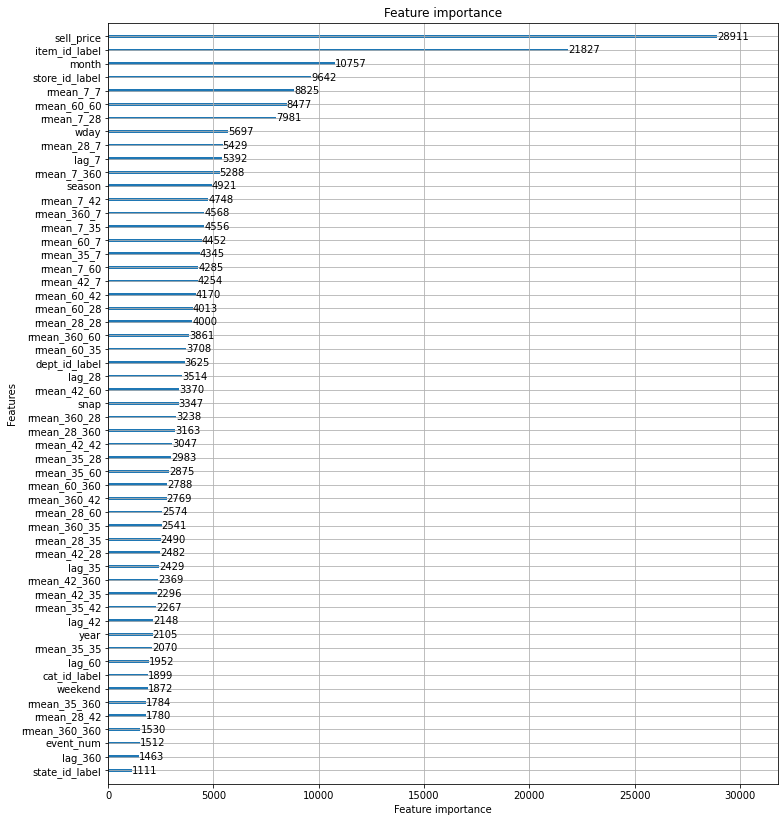

In [22]:
lgb.plot_importance(model, figsize= (12, 14))

We see that _sell_price_ and _item_id_ seem overwhelmingly important. This makes sense, however could probably be optimised with different lag/rolling features. In hindsight calculating rolling standard deviation would probably be a good idea, perhaps splitting up sales price somehow based on lags? My understanding of this isn't quite ideal yet, something to think about for the future.

NameError: name 'store_list' is not defined